### Ronaldlee Ejalu
### DSC 478 Programming Machine Learning Applications
# In this notebook, I am going to use the Newsgroup data set:
<ul>
<li>To create a KNN-Nearest classification using Euclidean distance and cosine.</li>
<li>Create an evaluation function to measure the accuracy of the classifier.</li>
<li>Run an Evaluation function on a range of values for k from 5 to 100 in order to compare accuracy for different number of neighbors.</li>
<li>modify the training and test data sets so that term weights are converted to TFxIDF weights (instead of raw term frequencies).</li>
<li>Create a new classifier based on the Rocchio Method (also know as the "nearest centroid" method) adapted for text categorization.</li>
<li>Using scikit-learn's Nearest Centroid classifier to perform classification of the test instances, as in the previous part</li>
</ul>

In [1]:
# load the necessary packages
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.style.use('ggplot')

### load the data sets

In [2]:
# load the testClasses data set
df_testClasses = pd.read_csv('../../data/newsgroups/testClasses.txt', sep = '\t' ,header = None, index_col = 0)
df_testClasses.head()


,1
0,
0,1
1,0
2,0
3,1
4,1


#### The testClasses dataset contains the labels associated with each test document. Each line is in the format of documentIndex \t classId where the documentIndex is in the range of [0,200) and refers to the index of the document in the term-document frequency matrix for test documents  

In [3]:
# load the testMatrixModified data set
df_testMatrixModified = pd.read_csv('../../data/newsgroups/testMatrixModified.txt', sep = '\t', header = None)
df_testMatrixModified.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### The testMatrixModified dataset is the term-document frequency for the test documents. The matrix contains 5500 rows and 200 columns.

In [4]:
numTermsT = df_testMatrixModified.shape[0]
print('number of Terms before Transposing: %s \n' %(numTermsT))
numDocsT = df_testMatrixModified.shape[1]
print('number of Docs before Transposing: %s \n' %(numDocsT))

number of Terms before Transposing: 5500 

number of Docs before Transposing: 200 



#### let's compute the term frequencies to get an idea of their distributions across the testing data set documents

In [5]:
testTermFreq = df_testMatrixModified.sum(axis=1)
testTermFreq

0        24.0
1         0.0
2         1.0
3       251.0
4        45.0
        ...  
5495      1.0
5496      3.0
5497      1.0
5498      1.0
5499      1.0
Length: 5500, dtype: float64

<p>David appears 24 , rex 0, wood 1 times in the testing data set. </p>

In [6]:
# load the trainClasses data set
df_trainClasses = pd.read_csv('../../data/newsgroups/trainClasses.txt', sep = '\t', header = None, index_col = 0)
df_trainClasses.head()

,1
0,
0,0
1,1
2,0
3,1
4,0


In [7]:
# qa
# np.array(df_trainClasses)[:,0]

#### The trainClasses data set contains the labels associated with each training document. Each line is in the format of documentIndex \t classId where the documentIndex is in the range of [0,800) and refers to the index of the document in the term-document frequency matrix for train documents. The classId refers to one of the two classes and takes one of the values 0 (for Windows) or 1 (for Hockey).

In [8]:
# load the trainMatrixModified data set

df_trainMatrixModified = pd.read_csv('../../data/newsgroups/trainMatrixModified.txt', sep = '\t', header = None)
df_trainMatrixModified.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
# # lets normalize all the attributes
# # we use the MinMaxScaler() from scikit-learn package
# min_max_scaler = preprocessing.MinMaxScaler() 
# min_max_scaler.fit(df_trainMatrixModified)

# vs_trainMatrixModified = min_max_scaler.fit_transform(df_trainMatrixModified) # apply it both on train and test
# vs_testMatrixModified = min_max_scaler.fit_transform(df_testMatrixModified)


#### The trainMatrixModified dataset is the term-document frequency matrix for the training documents. Each row of this matrix corresponds to one the terms and each column corresponds to one the documents and the (i,j)th element of the matrix shows the frequency of the ith term in the jth document. This matrix contains 5500 rows and 800 columns.

In [10]:
numTerms = df_trainMatrixModified.shape[0]
print('numTerms before Transposing: %s \n' %(numTerms))
numDocs = df_trainMatrixModified.shape[1]
print('numDocs before Transposing: %s \n' %(numDocs))

numTerms before Transposing: 5500 

numDocs before Transposing: 800 



#### Let's compute the term frequencies to get an idea of their distributions across the corpus

In [11]:
trainTermFreq = df_trainMatrixModified.sum(axis=1)
trainTermFreq

0       102.0
1        11.0
2        22.0
3       959.0
4       222.0
        ...  
5495      3.0
5496      3.0
5497      2.0
5498      2.0
5499      2.0
Length: 5500, dtype: float64

<p>We learn that David appears 102 times, rex 11 times, wood 22 times and e.t.c in the training data set.</p>

In [12]:
# load the modifiedterms data set
df_modifiedterms  = pd.read_csv('../../data/newsgroups/modifiedterms.txt', header = None)
df_modifiedterms.head()

,0
0,david
1,rex
2,wood
3,subject
4,call


#### This modifiedterms data set contains the set of 5500 terms in the vocabulary. Each line contains a term and corresponds to the corresponding rows in term-document frequency matrices. 

#### Lets transpose both the testing and training data sets into the right shapes for documents categorization. 

In [13]:
DT_trainMatrixModified = df_trainMatrixModified.T
DT_trainMatrixModified

,0,1,2,3,4,5,6,7,8,9,...,5490,5491,5492,5493,5494,5495,5496,5497,5498,5499
0,2.0,2.0,2.0,1.0,8.0,6.0,2.0,8.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
798,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
DT_testMatrixModified = df_testMatrixModified.T
DT_testMatrixModified

,0,1,2,3,4,5,6,7,8,9,...,5490,5491,5492,5493,5494,5495,5496,5497,5498,5499
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<p>Now we have our documents term matrices for both the training and test data sets.</p>

#### Lets convert both the training and testing data sets into numpy arrays, which will be used as inputs for our search function. 

In [15]:
DT_trainMatrixModified = np.array(DT_trainMatrixModified)
DT_trainMatrixModified

array([[2., 2., 2., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
DT_testMatrixModified = np.array(DT_testMatrixModified)
DT_testMatrixModified

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
#### Also, we convert the training and test target labels into Numpy arrays and transposing them

In [18]:
vs_target_train = np.array(df_trainClasses).flatten()
vs_target_test = np.array(df_testClasses).flatten()
print(vs_target_train[:10])
print(vs_target_test[:10])

[0 1 0 1 0 1 1 1 1 1]
[1 0 0 1 1 0 1 1 0 1]


## a. Deriving the K-Nearest-Neighbor classifier function

In [19]:
def knnSearch(queryObject, dMatrix, datasetL, k, distMeasure):
    """ 
    A function that returns the predicted class for 
    the instance and the indicies of the top k neighbours
    
    Input:
        queryObject is the instance to be classified
        dMatrix is the training data Matrix
        datasetL is the training Labels
        k is the number of neighbors
        distMeasure is the type of distance, either Euclidean or Cosine
    Output: The most popular class label and the indicies of the top K neighbors
    
    @author: Ronaldlee Ejalu
    """
    if distMeasure == 0:        # Using Euclidean distance
        dMatrixSetSize = dMatrix.shape[0]
    
        # we use tile to construct an array by repeating queryObject, the number of times we would like to repeat as per 
        diffMatrice = np.tile(queryObject, (dMatrixSetSize, 1)) - dMatrix
    
        squareDiffMatt = diffMatrice ** 2
        squaredDistances = squareDiffMatt.sum(axis = 1)
        dist = squaredDistances ** 0.5
        # print('distance before sorting\n %s' %(dist))
        # sortedDistanceIndicies = dist.argsort()
        sortedDistanceIndicies = np.argsort(dist) 
        
        # declare an empty dictionary for targetClass Counts
        targetCounts = {}
        for item in range(k):
            # print('item: %s sortedDistanceIndicies[item]: %s' %(item, sortedDistanceIndicies[item]))
            voteQObjectLabel = datasetL[sortedDistanceIndicies[item]] # assign the given target label to a string variable
            
            # lookup the target labels and whatever value is returned add 1 to it before inserting the output to the dictionary
            targetCounts[voteQObjectLabel] =  targetCounts.get(voteQObjectLabel, 0) + 1 
        sortedTargetCount = sorted(targetCounts.items(), 
                                   key = operator.itemgetter(1), 
                                   reverse = True
                                  )
    elif distMeasure == 1:
        # find the vector norm for each instance in D as well as the norm for vector x
        D_norm = np.array([np.linalg.norm(dMatrix[num]) for num in range(len(dMatrix))])
        x_norm = np.linalg.norm(queryObject)  # cosine distance
        
        # Compute Cosine: divide the dot product of queryObject and each instance in dMatrix by the product of the two norms
        cosines = np.dot(dMatrix, queryObject)/(D_norm * x_norm)
        
        # The distance measure will be the inverse of Cosine similarity
        dist = 1 - cosines
        sortedDistanceIndicies = np.argsort(dist) 
        
        # declare an empty dictionary for targetClass Counts
        targetCounts = {}
        for item in range(k):
            # print('item: %s sortedDistanceIndicies[item]: %s' %(item, sortedDistanceIndicies[item]))
            voteQObjectLabel = datasetL[sortedDistanceIndicies[item]] # assign the given target label to a string variable
            
            # lookup the target labels and whatever value is returned add 1 to it before inserting the output to the dictionary
            targetCounts[voteQObjectLabel] =  targetCounts.get(voteQObjectLabel, 0) + 1 
        sortedTargetCount = sorted(targetCounts.items(), 
                                   key = operator.itemgetter(1), 
                                   reverse = True
                                  ) 

    return sortedTargetCount[0][0], sortedDistanceIndicies[:k] # return the predicted class and the indicies of the the top k neighours
            
        
    

## b. Evaluation function to measure the accuracy of our classifier. This function calls the classifier implemented above on all the test instances and in each case compares the actual test class label to the predicted class label.

In [20]:
# Let's look at how many test items we have. 
numTestVecs = len(vs_target_test)
numTestVecs

200

In [21]:
def knnEval(dMatrix, datasetL, queryObject, vs_target_test, k, distMeasure):
    """
    An Evaluation function that measure the accuracy of a KNN classfier and returns the classificier's accuracy
    Input:
        dMatrix is the training data Matrix
        datasetL is the training Labels
        queryObject is the instance to be classified
        target_test labels
        k is the number of neighbors
        distMeasure is the type of distance, either Euclidean or Cosine
        
    Output:returns the classification accuracy
    
    @author: Ronaldlee Ejalu
    """
    errorCount = 0.0 
#     print('length of the query object is %s' %(len(queryObject)))
    
    for num in range(len(queryObject)):
        classificationResult = knnSearch(queryObject[num], dMatrix, datasetL, k, distMeasure)
#         print('The classifier came back with: %s, the real answer is: %s' %(classificationResult[0], vs_target_test[num]))
    
        # if it is not the same then increment the errors by 1 
        if classificationResult[0] != vs_target_test[num]:
            errorCount += 1.0
        
    # So, we count the number of mistakes we made
#     print(errorCount)
    errorRate = errorCount/float(len(queryObject)) 
    accuracy = 1 - errorRate
#     print('The total error rate is: %f' %(errorCount/float(numTestVecs)))
    return accuracy    # retur the classification accuracy

In [22]:
# Testing the KnnEval function
y = knnEval(DT_trainMatrixModified, vs_target_train, DT_testMatrixModified, vs_target_test, 3, 0)
y 

0.81

## c. Running the evaluation function on the range of values for k from 5 to 100 (in increments of 5) in order to compare accuracy values for different numbers of neighbors. 


In [23]:
%%time
# deriving range values of k from 5 to 100 in increments of 5
k = range(5, 100, 5)

# Euclidean distance

# Declare a list of an evaluated classifier using Euclidean Distance
eucliDistanceL = [] 


# looping through through the range of k values
# generate lists of evaluated classifiers using the Euclidean and Cosine Similarity distances
for i in range(len(k)):
#     print(k[i])
    #eucliAcc = knnEval(DT_testMatrixModified, DT_trainMatrixModified, vs_target_train, k[i], 0)
    eucliAcc = knnEval(DT_trainMatrixModified, vs_target_train, DT_testMatrixModified, vs_target_test, k[i], 0)
    eucliDistanceL.append(eucliAcc)

    
print('The Euclidean Distance list is %s' %(eucliDistanceL))

    

The Euclidean Distance list is [0.815, 0.85, 0.785, 0.765, 0.73, 0.725, 0.69, 0.7, 0.655, 0.6699999999999999, 0.655, 0.6599999999999999, 0.625, 0.625, 0.63, 0.615, 0.615, 0.61, 0.605]
Wall time: 7min 28s


In [24]:
%%time
# Cosine Similarity

# Declare a list of an evaluated classifier using cosine similarity
cosineSimL = []

# looping through through the range of k values
# generate lists of evaluated classifiers using the Euclidean and Cosine Similarity distances
for i in range(len(k)):
    # print(k[i])
   
    cosineAcc = knnEval(DT_trainMatrixModified, vs_target_train, DT_testMatrixModified, vs_target_test, k[i], 1)
    cosineSimL.append(cosineAcc)
    
print('The cosine Similarity list is %s' %(cosineSimL))
    

The cosine Similarity list is [0.97, 0.985, 0.985, 0.975, 0.97, 0.98, 0.98, 0.98, 0.975, 0.98, 0.975, 0.98, 0.975, 0.975, 0.975, 0.975, 0.975, 0.975, 0.975]
Wall time: 1min 4s


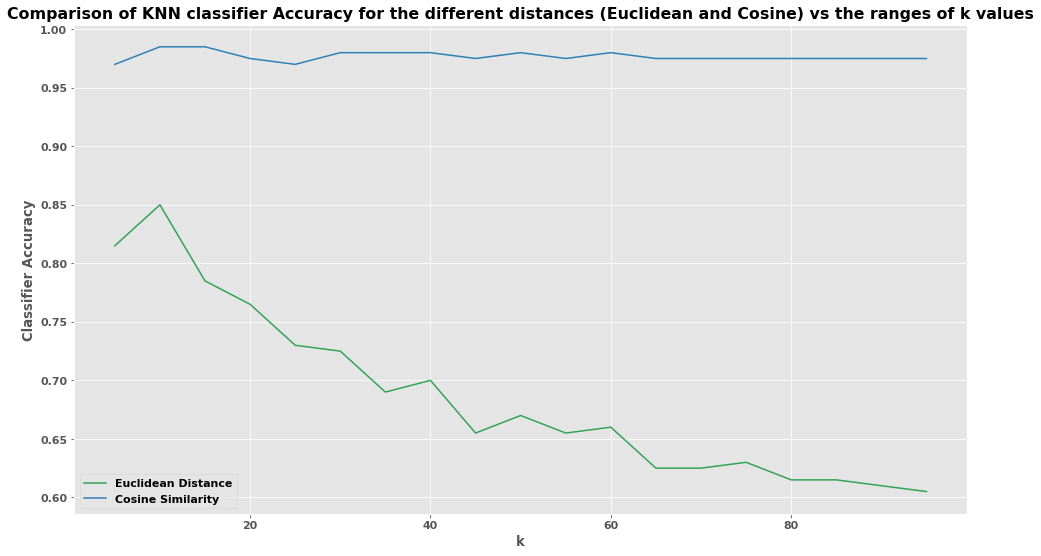

In [25]:
plt.rcParams.update({'font.size': 11}) # set the font size, this must be set at the top.
fig = plt.figure(figsize=(16, 9)) # set the size of the container
plt.plot(k, eucliDistanceL, color = '#31a354', label = 'Euclidean Distance')
plt.plot(k, cosineSimL, color = '#2c7fb8', label = 'Cosine Similarity')
plt.title('Comparison of KNN classifier Accuracy for the different distances (Euclidean and Cosine) vs the ranges of k values')
plt.xlabel('k')
plt.ylabel('Classifier Accuracy')
plt.legend()
plt.show()

<p>We see that with Euclidean distance, as the number of K values increases from 5 to 100, the classifier accuracy decreases.</p>
<p>Also, we see that this data set works well with Cosine Similarity since as k values increase the classifier accuracy does decrease at the rate we observe when Euclidean distance is used.Therefore, document data sets work well with Cosine Similarity. </p>

## d. Modify the training and test data sets so that term weights are converted to TFxIDF weights (instead of raw term frequencies).Then, rerun your evaluation (only for the Cosine similarity version of the classifier) on the range of K values (as above) and create a chart comparing the results with and without using TFxIDF weights.

In [26]:
# numTermsT = df_testMatrixModified.shape[0]
# numDocsT = df_testMatrixModified.shape[1]

# numTerms = df_trainMatrixModified.shape[0]
# numDocs = df_trainMatrixModified.shape[1]

##### let's transform the data to TF*IDF weights:

In [27]:
# Note: document frequency (df) for a term t is the number of documents in which t appears divided by total number of documents

# let's first find the document counts for each term in both the training and testing data sets
DF_train = pd.DataFrame([(df_trainMatrixModified != 0).sum(1)]).T # we are checking where a term is not non zero and summing it along the column direction.

DF_test = pd.DataFrame([(df_testMatrixModified != 0).sum(1)]).T
print('The first five document counts for each term from the training set')
print(DF_train.head())
print('')
print('The first five document counts for each term from the testing set')
print(DF_test.head())


The first five document counts for each term from the training set
     0
0   50
1    7
2   10
3  800
4  108

The first five document counts for each term from the testing set
     0
0   15
1    0
2    1
3  200
4   26


#### Create a matrice with all entries =  numDocsT, numDocs for both the training and testing data sets.

In [28]:
print(numDocs)

800


In [29]:
print(numDocsT)

200


In [30]:
# we are creating a matrix with a shape of training and testing data set 
# and we are filling it with a number of documents. 

# First: training data set.
nMatrixTrain = np.ones(np.shape(df_trainMatrixModified), dtype=float) * numDocs
np.set_printoptions(precision=2,suppress=True,linewidth=120)
# print(Tmatrix)
print('nMatrixTrain')
print(nMatrixTrain.shape)

print('')

# second: testing data set
nMatrixTest = np.ones(np.shape(df_testMatrixModified), dtype=float) * numDocsT 
print('nMatrixTest')
# print(nMatrixTest)
print(nMatrixTest.shape)


nMatrixTrain
(5500, 800)

nMatrixTest
(5500, 200)


In [31]:
# Convert each entry into IDF values
# IDF is the log of the inverse of document frequency
# Note that IDF is only a function of the term, so all columns will be identical.

# we are going to divide TMatrix by DF.
# it is the inverse document frequency then we are going to take the log 2 of that.
IDF_values_Train = np.log2(np.divide(nMatrixTrain, np.array(DF_train)))
print(IDF_values_Train)

IDF_values_test = np.log2(np.divide(nMatrixTest, np.array(DF_test) + 1)) 
IDF_values_test

[[4.   4.   4.   ... 4.   4.   4.  ]
 [6.84 6.84 6.84 ... 6.84 6.84 6.84]
 [6.32 6.32 6.32 ... 6.32 6.32 6.32]
 ...
 [8.64 8.64 8.64 ... 8.64 8.64 8.64]
 [8.64 8.64 8.64 ... 8.64 8.64 8.64]
 [8.64 8.64 8.64 ... 8.64 8.64 8.64]]


array([[3.64, 3.64, 3.64, ..., 3.64, 3.64, 3.64],
       [7.64, 7.64, 7.64, ..., 7.64, 7.64, 7.64],
       [6.64, 6.64, 6.64, ..., 6.64, 6.64, 6.64],
       ...,
       [6.64, 6.64, 6.64, ..., 6.64, 6.64, 6.64],
       [6.64, 6.64, 6.64, ..., 6.64, 6.64, 6.64],
       [6.64, 6.64, 6.64, ..., 6.64, 6.64, 6.64]])

In [32]:
# np.array(DF_test) + 1

In [33]:
# Finally compute the TF * IDF  values for each document-term entry.
trainMatrixModified_tfidf = df_trainMatrixModified * IDF_values_Train
pd.set_option("display.precision", 2) 
print('trainMatrixModified_tfidf')
print(trainMatrixModified_tfidf.shape)
print(trainMatrixModified_tfidf)

print('\n\ntestMatrixModified_tfidf')

# Each term in query x must be multiplied by the idf value of the term we computed earlier (the IDF matrix)
# x is our query object to be used. 
testMatrixModified_tfidf = df_testMatrixModified * IDF_values_test #IDF_values_Train[:, 0:200]
testMatrixModified_tfidf


trainMatrixModified_tfidf
(5500, 800)
        0     1    2    3    4    5    6    7    8    9    ...  790  791  \
0      8.00  0.00  0.0  8.0  8.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1     13.67  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2     12.64  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3      0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4     23.11  2.89  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...     ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5495   0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5496   0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5497   0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5498   0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5499   0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

        792  793  794  795  796  797  798   799  

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.00e+00,0.00e+00,3.64e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
1,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
2,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
3,-7.20e-03,-7.20e-03,-7.20e-03,-7.20e-03,-7.20e-03,-7.20e-03,-0.01,-7.20e-03,-7.20e-03,-7.20e-03,...,-7.20e-03,-0.01,-7.20e-03,-7.20e-03,-7.20e-03,-7.20e-03,-7.20e-03,-7.20e-03,-7.20e-03,-7.20e-03
4,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00e+00,5.78e+00,0.00e+00,...,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
5496,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
5497,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
5498,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00


In [34]:
# The KNN Search function expects a document x term matrix as an np array, so we need to transpose the TF_tfidf matrix

# Now remember we had term by document, we didn't have document by term so remember you have to transpose it to document by term 
# becuase that is your features
DT_trainMatrixModified_tfidf = trainMatrixModified_tfidf.T

DT_testMatrixModified_tfidf = testMatrixModified_tfidf.T

# then you to convert it to a numpy array
trainMatrixModified_tfidf_array = np.array(DT_trainMatrixModified_tfidf)
testMatrixModified_tfidf_array  = np.array(DT_testMatrixModified_tfidf)
print(trainMatrixModified_tfidf_array)
print('')
print(testMatrixModified_tfidf_array)



[[ 8.   13.67 12.64 ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]]

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [3.64 0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


In [35]:
%%time
# Declare a list of an evaluated classifier using cosine similarity
cosineSim_TFxIDF_L = []

# looping through through the range of k values
# generate lists of evaluated classifiers using the Cosine Similarity distances with data set 
# whose term weights are converted to TFxIDF  
for i in range(len(k)):
#     print(k[i])
    cosineAcc_tfidf = knnEval(trainMatrixModified_tfidf_array, vs_target_train, testMatrixModified_tfidf_array, vs_target_test, k[i], 1)
    cosineSim_TFxIDF_L.append(cosineAcc_tfidf)
    
print('The cosine Similarity list is %s' %(cosineSimL))
    

The cosine Similarity list is [0.97, 0.985, 0.985, 0.975, 0.97, 0.98, 0.98, 0.98, 0.975, 0.98, 0.975, 0.98, 0.975, 0.975, 0.975, 0.975, 0.975, 0.975, 0.975]
Wall time: 1min 2s


#### A chart that compares the classification accuracy with and without usingTFxIDF

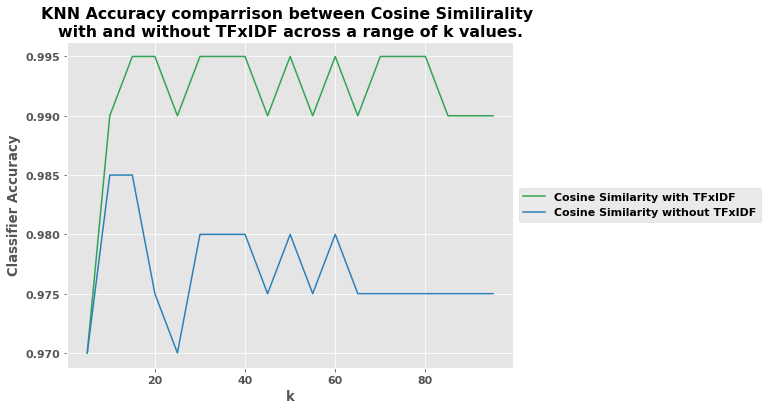

In [36]:
plt.rcParams.update({'font.size': 11}) # set the font size, this must be set at the top.
fig = plt.figure(figsize=(8, 6)) # set the size of the container
plt.plot(k, cosineSim_TFxIDF_L, color = '#31a354', label = 'Cosine Similarity with TFxIDF')
plt.plot(k, cosineSimL, color = '#2c7fb8', label = 'Cosine Similarity without TFxIDF')
plt.title('KNN Accuracy comparrison between Cosine Similirality \nwith and without TFxIDF across a range of k values.')
plt.xlabel('k')
plt.ylabel('Classifier Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<p>The chart above shows that KNN performs better using Cosine similarity with TFxIDF weights. <p>

#### Rocchio Method (Nearest centroid method)

In [37]:
def rocchioTrain(dTrainMatrix, targetTrainLabels):
    """ 
    A function that returns prototype vector for each class
    """
    
    # stack the train labels numpy array to the training matrix numpy array as columns
    genPrototype = np.column_stack((dTrainMatrix, targetTrainLabels))
    # print(generalPrototype)
    
    proTypeClass1 = np.array(np.zeros(genPrototype.shape[1]))
    proTypeClass2 = np.array(np.zeros(genPrototype.shape[1]))
    
    # iterate through the matrix numpy array (training documents stacked together with the labels)
    # and compute the prototype vector for each class
    # by summing the vectors of the training documents stacked together with the labels 
    # in that class or category
    for num in genPrototype:
        #         print(num)
        if num[-1] == 0:
            proTypeClass1 += num
        else:
            proTypeClass2 += num

    return proTypeClass1,  proTypeClass2 # return the prototype vector of each class. 

In [38]:
# QA
#DT_trainMatrixModified
pvClass1, pvClass2 = rocchioTrain(DT_trainMatrixModified_tfidf, vs_target_train)
print(pvClass1)
print(pvClass2)
pvClass2[:-1]

[228.    27.35  31.61 ...  17.29  17.29   0.  ]
[180.    47.86 107.47 ...   0.     0.   399.  ]


array([180.  ,  47.86, 107.47, ...,   8.64,   0.  ,   0.  ])

In [39]:
def rocchioClassifier(pvClass1, pvClass2, instance): #, instance
    """
    A function that returns the predicted class for the test instance 
    and the similarity values of the instance to each of the category prototypes
    """
    
    class1Norm = np.linalg.norm(pvClass1[:-1])
    class2Norm = np.linalg.norm(pvClass2[:-1])
    instanceNorm = np.linalg.norm(instance)
    
    # derive the cosine sims of the test instance to each prototype vector
    cosineSim1 = np.dot(pvClass1[:-1], instance) / (class1Norm * instanceNorm)
    cosineSim2 = np.dot(pvClass2[:-1], instance) / (class2Norm * instanceNorm)
    
    # measure the cosine  similarity of 
    if cosineSim1 >= cosineSim2:
        predicatedClass = 0
        sims = cosineSim1
    else:
        predicatedClass = 1
        sims = cosineSim2
    
    return predicatedClass, sims   # return the predicted class and the maximum cosine similarity

In [40]:
# # # QA 
# predicatedLabels, sims = rocchioClassifier(pvClass1, pvClass2, DT_testMatrixModified_tfidf) 
# print()
# print(sims)

In [41]:
def rocchio_evaluate(test, test_lab, prototype):
    """ 
    A function that returns the accuracy of the classifier 
    after comparing it to the best KNN results obtained in d
    """
    return accuracy

#### Using scikit-learn's Nearest Centroid classifier to perform classification of the test instances, as in the previous part.

In [42]:
# Build the Nearest Centroid Classifier
clf = NearestCentroid()
clf.fit(trainMatrixModified_tfidf_array, vs_target_train)
NearestCentroid(metric = 'cosine', shrink_threshold = None)


NearestCentroid(metric='cosine')

#### So, we predict on the entire test instance TFxIDF matrix 

In [43]:
clspreds_test = clf.predict(testMatrixModified_tfidf_array)
clspreds_test[0:10] # the first 10
# O label is for Windows
# 1 is for Hockey

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int64)

In [44]:
# let's evaluate the classifier accurcy
from sklearn.metrics import classification_report
print(classification_report(vs_target_test, clspreds_test, labels = [1, 0]))

              precision    recall  f1-score   support

           1       0.75      1.00      0.86       101
           0       1.00      0.67      0.80        99

    accuracy                           0.83       200
   macro avg       0.88      0.83      0.83       200
weighted avg       0.88      0.83      0.83       200



<p>They were 99 examples used to justify these the class 0 numbers and 101 example used to justify the class 1 numbers.</p>
<p>A precision score of 0.75 for class 1 (Hockey) means that every turple that the classifier labeled as belonging to class 1 does indeed belong to class 1, however we don't know anything about the number of class  tuples that the classifier mislabeled.</p>
<p>Also, a perfect recall score of 1.0 for class 1 (Hockey) implies that every item from class 1 was labeled as such, but it doesn't tell us how many other tuples were incorrectly labeled as belonging to class 1.</p>
<p>Even though our model has a good accuracy of 0.83, it has a low specificity of 0.67, meaning that it doesn't recognize negative (Microsoft Windows) tuples so well.</p>

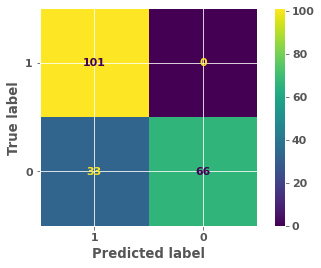

In [45]:
# derive the confusion matrix to evaluate the accuracy of the classification
clfcm = confusion_matrix(vs_target_test, clspreds_test, labels = [1,0])
clfcm_display = ConfusionMatrixDisplay(clfcm, display_labels = [1, 0])
clfcm_display.plot();

<p>101 positive  class  data points (Hockey) were correctly classified by the model.</p>
<p>66 negative class data points (Microsoft Windows) were correctly classified by the model.</p>
<p>33 positive class data points (Hockey) were incorrectly classified as belonging to the negative class (Microsoft Windows) by the model.</p>
<p>There weren't any negative class (Microsoft Windows) data points incorrectly class as belonging to the positive class (Hockey) by the model.</p>

In [46]:
# compute the average accuracy score across the test instances
print(clf.score(testMatrixModified_tfidf_array,vs_target_test))

0.835


#### 83.5% is the accuracy for the model and this classifier would have been more effective if negative class data points (window) that were incorrectly classified as belonging to the positive class (Hockey) by the model (FN) were 0. 

In [47]:
# compute the average accuracy score across the training instances
print(clf.score(trainMatrixModified_tfidf_array, vs_target_train))

0.8575


#### 85.8% is the accuracy for our training  data set and 83.5% is the accuracy for our test data set.

<p>There is a slight difference of 2.3% of the average accuracy scores between the training and testing instances, and this raises some questions whether we have enough training data. Also, our model is being overfitted on the training data which makes it hard enough to learn something in general.</p> 

In [48]:
# neigh_idx, testLabel = knnSearch(DT_testMatrixModified[101], DT_trainMatrixModified, vs_target_train, 3, 1)
# print(neigh_idx)
# print(testLabel)